## Importante: todos los experimentos realizados fueron ejecutados en los computadores del laboratorio INCA del departamento de informática, los cuales cuentan con tarjetas de video NVIDIA 1080TI. En este informe sólo se presentan los resultados obtenidos.

<a id="primero"></a>
## 1. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />

Descargue los datos de la página de Kaggle y cárguelos mediante pandas.

In [189]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

In [190]:
df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [191]:
df_ner

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O
5,5,through,london,to,TO,lowercase,to,NNP,capitalized,London,...,have,VBP,lowercase,have,lowercase,marched,1.0,lowercase,through,O
6,6,london,to,protest,VB,lowercase,protest,TO,lowercase,to,...,march,VBN,lowercase,marched,lowercase,through,1.0,capitalized,London,B-geo
7,7,to,protest,the,DT,lowercase,the,VB,lowercase,protest,...,through,IN,lowercase,through,capitalized,London,1.0,lowercase,to,O
8,8,protest,the,war,NN,lowercase,war,DT,lowercase,the,...,london,NNP,capitalized,London,lowercase,to,1.0,lowercase,protest,O
9,9,the,war,in,IN,lowercase,in,NN,lowercase,war,...,to,TO,lowercase,to,lowercase,protest,1.0,lowercase,the,O


In [192]:
def plot_frame(title,xlabel,ylabel):
    plt.figure(figsize=(8,6))
    ax =plt.subplot(111)
    
    #plt.plot(recall)
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    plt.xlabel(xlabel,fontsize=16)
    plt.ylabel(ylabel,fontsize=16)
    plt.title(title,fontsize=16)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  

a) En esta primera instancia trabajaremos con la tarea de realizar un NER tag (Named Entity Recognition) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo many to many, es decir, la entrada es una secuencia y la salida es una secuencia, sin shift, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset ¿Por qué es conveniente utilizar lemma en vez de la palabra misma word?

In [193]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

In [194]:
dataset.head(20)

,lemma,word,pos,tag,prev-iob
0,thousand,Thousands,NNS,O,__START1__
1,of,of,IN,O,O
2,demonstr,demonstrators,NNS,O,O
3,have,have,VBP,O,O
4,march,marched,VBN,O,O
5,through,through,IN,O,O
6,london,London,NNP,B-geo,O
7,to,to,TO,O,B-geo
8,protest,protest,VB,O,O
9,the,the,DT,O,O


>Named Entity Recognition es la tarea de encontrar y clasificar entidades nombradas en un texto. Una entidad nombrada es un conjunto de palabras que hacen referencia a una entidad del mundo real, tal como una persona o una ubicación geográfica.

>Los lemmas corresponden a las raíces semánticas de las palabras. Así, palabras en diversas conjugaciones tienen el mismo lemma, con lo cual se reduce el tamaño del vocabulario. En este sentido, es conveniente trabajar con lemmas, ya que un vocabulario con las palabras conjugadas requeririría de un mapeo a embeddings mucho más complejo y un corpus más grande. Como desventaja, por otro lado, estamos perdiendo información valiosa que podría ser útil para identificar las entidades.

Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los las etiquetas (tags), esto es un arreglo de arreglos de lemmas y un arreglo de arreglos de tags respectivamente. ¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?

In [195]:
dataX,dataY = [],[]
lemmas,labels = set(), set()  #uniques
sentence = []
labels_sentence = []
for fila in dataset.values:
    if fila[-1]=="__START1__":  
        #print(sentence)
        if len(sentence) > 0:
            #print("here")
            dataX.append(np.asarray(sentence))
            dataY.append(np.asarray(labels_sentence))
        sentence = []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[3]) #TAG
dataX = np.asarray(dataX[:]) #data to  array
dataY = np.asarray(dataY[:])

> Debido a que los datos corresponden a las sentencias extraídas del corpus, y tomando cada dato como el conjunto de palabras que componen la sentencia, es claro que la dimensión de los datos es variable, ya que el largo de las sentencias no siempre es el mismo. Por su parte, cada palabra de cada sentencia tiene asociado un tag, con lo que la estructura de entrada y de salida asociada a la misma sentencia tienen las mismas dimensiones. En el próximo punto estudiaremos la distribución del largo de las sentencias. A continuación mostramos las posibles etiquetas de las entidades:

In [233]:
labels

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

>Investigando, la letra mayúscula B indica si la palabra es el inicio de una entidad nombrada, y luego I indica que la palabra es parte de la última palabra etiquetada con B. Así, la entidad "profesor Carlos Valle" debería ser etiquetada con una B en "profesor" y con una I tanto en "Carlos" como "Valle", para poder reconocer a las 3 palabras como la misma entidad. Las 3 letras de la derecha tienen los siguientes significados que clasifican el tipo de entidad:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

> Por último, "O" significa que la palabra no es una entidad.

b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

In [196]:
sentence_lengths = list(map(len, dataX))

In [199]:
def map_to_dict(word):
    try:
        vocabulary[word] += 1
    except:
        vocabulary[word] = 1

vocabulary = {}

for i in range(len(dataX)):
    list(map(map_to_dict,dataX[i]))        

In [197]:
freqs = [count for word, count in vocabulary.items()]
freqs.sort(reverse=True)

In [198]:
def map_to_dict(word):
    try:
        class_dict[word] += 1
    except:
        class_dict[word] = 1

class_dict = {}

for i in range(len(dataY)):
    list(map(map_to_dict,dataY[i]))  

In [200]:
classes = []
frequencies = []

for word, count in class_dict.items():
    classes.append(word)
    frequencies.append(count)


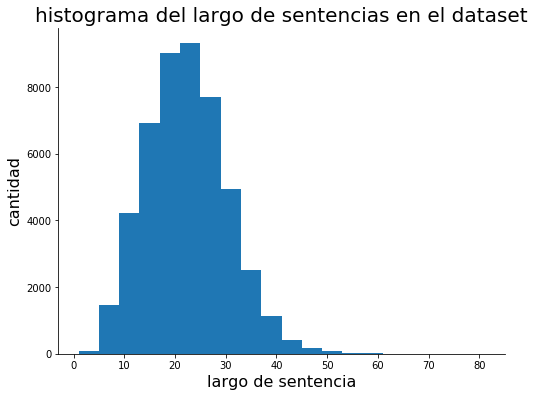

In [201]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)
x = np.arange(50)
plt.hist(sentence_lengths, bins = 20)
#plt.plot(recall)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("cantidad", fontsize=16)
plt.xlabel("largo de sentencia", fontsize=16)
#plt.xlim(0,len(signal)+24)
#plt.ylim(-0.1,1.1)
plt.title('histograma del largo de sentencias en el dataset', fontsize=20)

plt.show()

> Se observa que el largo de las sentencias no se distribuye uniformemente, habiendo una mayor concentración de sentencias de largo entre 15 a 25 palabras.

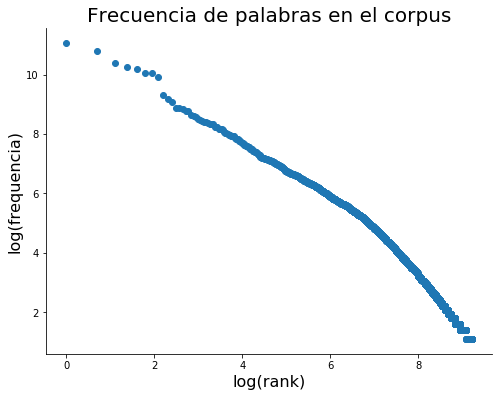

In [202]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)
x = np.arange(50)
rank = 10000
plt.scatter(np.log(np.arange(1,rank+1)),np.log(freqs[:rank]))
#plt.plot(recall)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("log(frequencia)", fontsize=16)
plt.xlabel("log(rank)", fontsize=16)
#plt.xlim(0,len(signal)+24)
#plt.ylim(-0.1,1.1)
plt.title('Frecuencia de palabras en el corpus', fontsize=20)

plt.show()

>La ley de Zipf es una ley empírica que establece que la frecuencia de las palabras de una lengua puede aproximarse según:

$$ \begin{equation} \displaystyle f_n \sim \frac{1}{n^a} \end{equation} $$

>en donde $n$ corresponde al ranking de la palabra y $f_n$ su frecuencia. Esto implica que si realizamos un gráfico $log(f_n)$ vs $log(n)$ debiésemos observar algo similar a una recta con pendiente negativa, ya que:

$$ \begin{equation} \displaystyle log(f_n) \sim -a log(n) \end{equation} $$

>Es claro a partir del gráfico que este es el caso para los palabra encontradas en el corpus. Aquellas palabras de mayor frecuencia contienen menos información, ya que aparecen en una mayor multiplicidad de contextos y no aportan tanto, por ende, a tareas en donde es necesario entender el significado de un texto. Aquellas palabras con menor frecuencia son mucho más específicas, por lo que entregan mucha más información.

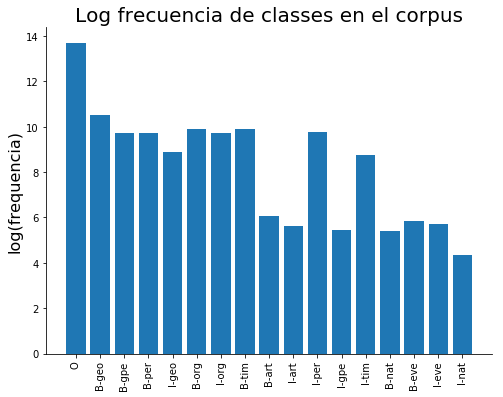

In [203]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)
x = np.arange(50)
plt.bar(classes,np.log(frequencies))
#plt.plot(recall)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("log(frequencia)", fontsize=16)
#plt.xlabel("largo de sentencia", fontsize=16)
#plt.xlim(0,len(signal)+24)
#plt.ylim(-0.1,1.1)
plt.title('Log frecuencia de classes en el corpus', fontsize=20)
plt.xticks(rotation='vertical')
plt.show()

>Finalmente, observamos la distribución de las clases con las que trabajaremos. Notar que el gráfico está en escala logarítmica, debido a que la diferencia en frecuencias es sustancial. Estas diferencias implican que se debe utilizar una métrica distinta al accuracy a la hora de comparar los métodos, ya que sólo con predecir "O" tendríamos un accuracy mayor al 90\%. 

c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo que será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. **Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas**. Además de esto, debido al largo distinto de las sentencias se deberá **realizar *padding* para estandarizar el largo**, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*0, 0*].

In [204]:
lemma2idx = {w: i+1 for i, w in enumerate(lemmas)} #Converting text to numbers
idx2lemma = {i+1: w for i, w in enumerate(lemmas)}
lab2idx = {t: i+1 for i, t in enumerate(labels)}
idx2lab = {i+1: t for i, t in enumerate(labels)}

X = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
Y = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)

In [205]:
max_input_length = np.max(sentence_lengths)

In [206]:
max_input_length

81

> Observamos que el largo máximo de las sentencias es 81 lemmas. Así mismo, la mayor cantidad de etiquetas es también 81, ya que las sentencias y etiquetas tienen el mismo largo en todos los casos.
El utilizar padding es necesario para poder realizar el entrenamiento de los modelos: si bien las redes recurrentes pueden trabajar con secuencias de largo variable, los batch utilizados tienen que tener las mismas dimensiones para poder aplicar operaciones con tensores y paralelizar, dentro de lo posible, el algoritmo. Así, hemos escogido utilizar el 0 como caracter especial para realizar el padding tanto en las entradas como las etiquetas.

d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece más conveniente al rellenar con un valor especial respecto al cómo funciona una red recurrente y cómo funciona su memoria **¿Al principio o al final de la sentencia?** Comente

In [207]:
from keras.preprocessing import sequence

X_pre = sequence.pad_sequences(X,maxlen=max_input_length,padding='pre',value=0) 
Y_pre = sequence.pad_sequences(Y,maxlen=max_input_length,padding='pre',value=0)

X_post = sequence.pad_sequences(X,maxlen=max_input_length,padding='post',value=0) 
Y_post = sequence.pad_sequences(Y,maxlen=max_input_length,padding='post',value=0)

> En la mayoría de los casos el padding debiese hacerse antes de la sentencia, ya que hacerlo después podría afectar a la tarea de predicción, llenando a la red con memoria basura que reemplace a la información importante . En este caso, sin embargo, las predicciones importantes ocurren desde el inicio de la sentencia, por lo que realizar padding antes podría afectar el desempeño del modelo en las predicciones de las palabras iniciales. Desde este punto de vista, utilizar padding después de la sentencia, no debería tener ningún efecto adverso, ya que toda la información innecesaria llegará después de que la red haya realizado las predicciones importantes. En términos de entrenamiento, sin embargo, sí pueden existir problemas con padding después de la sentencia, ya que el gradiente de los timesteps con padding se propagarán hacia el pasado y esto puede llevar a alterar el funcionamiento de la red en los timesteps que son relevantes. 

> Así, debido a que el gradiente se va desvaneciendo hacia timesteps del pasado, es menos la chance de que se vea alterado el desempeño del modelo en las predicciones más cercanas al inicio; el efecto debería ser más notorio al final. No nos queda más que comparar ambos tipos de padding y elegir aquel que tenga el mejor desempeño.

e) Para el poder entregar una clasificación sobre los distintos *tags* es necesario tranformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

In [114]:
from sklearn.model_selection import train_test_split
X_pre_train, X_pre_test, y_pre_train_n, y_pre_test_n = train_test_split(X_pre, Y_pre, test_size=0.3,random_state=22)
X_post_train, X_post_test, y_post_train_n, y_post_test_n = train_test_split(X_post, Y_post, test_size=0.3,random_state=22)

from keras.utils import to_categorical
y_train_pre = np.asarray([to_categorical(i, num_classes=n_labels+1) for i in y_pre_train_n])
y_test_pre = np.asarray([to_categorical(i, num_classes=n_labels+1) for i in y_pre_test_n])

y_train_post = np.asarray([to_categorical(i, num_classes=n_labels+1) for i in y_post_train_n])
y_test_post = np.asarray([to_categorical(i, num_classes=n_labels+1) for i in y_post_test_n])

In [115]:
X_pre_train.shape

(33656, 81)

In [116]:
X_pre_test.shape

(14425, 81)

In [117]:
y_train_pre.shape

(33656, 81, 18)

In [119]:
y_test_pre.shape

(14425, 81, 18)

> Los conjuntos de entrenamiento tiene 33656 muestras mientras que los conjuntos de test tienen 14425. La segunda dimensión de los conjuntos de entrada es 81, 1 por cada número que representa a una posible palabra/padding. La segunda dimensión de los conjuntos de salida es también 81, ya que se utiliza una etiqueta por cada posible palabra/padding, pero además tienen una dimensión extra, la que indica las posibles 17 clases más la clase comodín para representar al padding en la salida. 

f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

In [118]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_length))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels+1, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 18)            1818      
Total params: 702,826
Trainable params: 702,826
Non-trainable params: 0
_________________________________________________________________


> El embedding corresponde a una representación vectorial de las palabras en donde se espera que las representaciones aprendidas contengan información relevanta para la tarea en cuestión. Por ejemplo, se esperaría que palabras correspondientes a el contexto de palabras que son NER queden cercanos en el espacio de embedding, para que luego el algoritmo pueda clasificar correctamente nuevas entidades a partir de las palabras que la acompañan. Ahora, es acá donde la ley de Zift nos juega en contra, ya que muchas palabras serán de tan baja frecuencia que será difícil aprender un embedding apropiado para éstas. 

> La dimensión de la matriz que realiza el embedding siempre será de $d \times |V| $, en donde $|V|$ es el tamaño del vocabulario y $d$ es la dimensión de embedding. Como cada palabra del vocabulario es inicialmente representada por un one-hot vector, podemos ver la transformación que sufre este vector como una indexación del vector columna de la matriz que corresponde a la representación de la palabra. 

Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases como identificó en el punto b).

In [ ]:
model_pre.fit(X_pre_train, y_pre_train, validation_data=(X_pre_test, y_pre_test), epochs=3, batch_size=128)
model_post.fit(X_post_train, y_post_train, validation_data=(X_post_test, y_post_test), epochs=3, batch_size=128)

> Utilizaremos el f-score ponderado por el inverso de la proporción de cada etiqueta, con tal de que cada f-score por separado tenga la misma relevancia en la ponderación. Además, las métricas serán calculadas desechando las predicciones en los timesteps de padding, ya que las predicciones en esos puntos no nos interesan. Compararemos los resultados con embedding antes de la sentencia vs después de la sentencia para ver cuál tiene mejores resultados

In [239]:
from sklearn.metrics import f1_score
relevant_index = np.argwhere(y_pre_test_n.flatten() != 0)
relevant_y = y_test_pre_n.flatten()[relevant_index] 
relevant_predicted = model_pre.predict_classes(X_pre_test,verbose=0).flatten()[relevant_index] 
pre_score = f1_score(relevant_y-1,relevant_predicted-1, average='weighted')

relevant_index = np.argwhere(y_post_test_n.flatten() != 0)
relevant_y = y_test_post_n.flatten()[relevant_index] 
relevant_predicted = model_post.predict_classes(X_post_test,verbose=0).flatten()[relevant_index] 
post_score = f1_score(relevant_y-1,relevant_predicted-1, average='weighted')

In [201]:
f = np.loadtxt('f.txt')

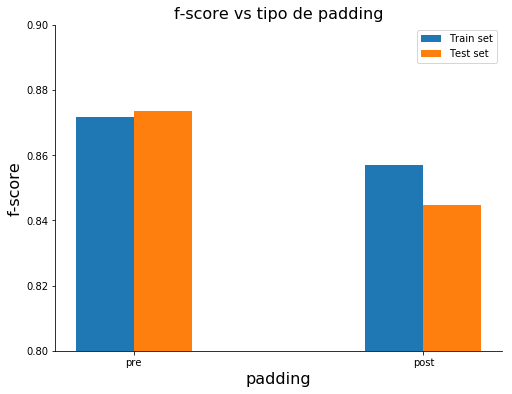

In [247]:
plot_frame('f-score vs tipo de padding','padding','f-score')
labels = ['pre','post']
placement = np.array([0,1])
plt.bar(placement-0.1, [f[3],f[2]], width=0.2, label='Train set')
plt.bar(placement+0.1, [f[0],f[1]], width=0.2, label='Test set')
plt.bar(labels, [0,0], width=0.2, align='center')
plt.ylim(0.8,0.9)
plt.legend()
plt.show()

> Se observa que el f-score utilizando el padding antes de la sequencia obtiene mejores resultados tanto en el train set como el test set. Además, el desempeño en ambos conjuntos es similar para el padding "pre"; no así con el padding "post", en el que el desempeño disminuye bastante, sugiriendo que la red tuvo que sobre-ajustar para compensar la problemática. Desde ahora en adelante, entonces, trabajaremos con el padding "pre".

In [209]:
X = sequence.pad_sequences(X,maxlen=max_input_length,padding='pre',value=0) 
Y = sequence.pad_sequences(Y,maxlen=max_input_length,padding='pre',value=0)

X_train, X_test, y_train_n, y_test_n = train_test_split(X, Y, test_size=0.3,random_state=22)

y_train = np.asarray([to_categorical(i, num_classes=n_labels+1) for i in y_train_n])
y_test = np.asarray([to_categorical(i, num_classes=n_labels+1) for i in y_test_n])

g) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

> La dimensionalidad del embedding influye en la cantidad de características con las cuales podemos representar las palabras del vocabulario. Si el embedding es muy pequeño, no tendremos la cantidad de características suficientes como para aprender la representación óptima de las palabras. Si, por otro lado, el embedding es muy grande, podemos aprender características ruidosas, no relevantes para la tarea, que nos lleven a overfittear. Probaremos con las siguientes dimensiones: 16, 32, 64 y 128. 

In [210]:
embeddings = [16, 32, 64, 128]

for embedding_vector in embeddings:
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_length))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dense(n_labels+1, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    #model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 16)            323904    
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           46800     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 18)            1818      
Total params: 372,522
Trainable params: 372,522
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_3 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dens

In [233]:
results_test = np.loadtxt('embeddings.txt')
results_train = np.loadtxt('embeddings_train.txt')

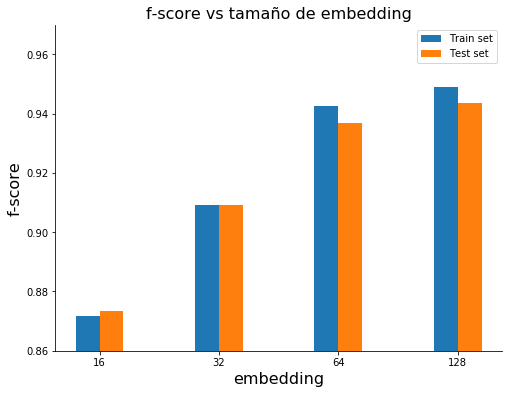

In [246]:
plot_frame('f-score vs tamaño de embedding', 'embedding','f-score')
labels = ['16','32','64','128']
placement = np.array([0,1,2,3])
plt.bar(placement-0.1, results_train, width=0.2, label='Train set')
plt.bar(placement+0.1, results_test, width=0.2, label='Test set')
plt.bar(labels, [0,0,0,0], width=0.2, align='center')
#plt.title('f-score vs tamaño de embedding')
#plt.xlabel('embedding')
plt.ylim(0.86,0.97)
plt.legend()
plt.show()

> Observamos como al aumentar el tamaño del embedding mejora los resultados tanto en el train set como en el test set. Es claro que hay una mayor diferencia entre el error en el train y test en los embeddings más grandes, tal como se esperaba. Sin embargo, la mayor capacidad del embedding hace que esta diferencia se compense respecto del ruido agregado a la representación. Así, desde ahora en adelante trabajaremos con el embedding de tamaño 120.

h) Use *Dropout* para entrenar la LSTM. **¿El *Dropout* mejora el desempeño de la red?** Señale cuáles podrı́an ser las causas del comportamiento observado.

> Experimentos pre-eliminares nos muestran que utilizar Dropout no cambia los resultados del modelo entrenado con embedding de tamaño 128. Para estar seguros, repetiremos el experimento 5 veces, midiendo sólo en el test set, con distintas inicializaciones de pesos, con tal de que podamos verificar o descartar que la similaridad obtenido no fue producto sólo del azar.

In [ ]:
embedding_vector = 128

scores = []
scores_train = []

for i in range(5):
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_length))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(n_labels+1, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    
    elevant_index = np.argwhere(y_test_n.flatten() != 0)
    relevant_y = y_test_n.flatten()[relevant_index] 
    relevant_predicted = model.predict_classes(X_test,verbose=0).flatten()[relevant_index] 
    
    
    score = f1_score(relevant_y-1,relevant_predicted-1, average='weighted')
    scores.append(score)
    
    relevant_index = np.argwhere(y_train_n.flatten() != 0)
    relevant_y = y_train_n.flatten()[relevant_index] 
    relevant_predicted = model.predict_classes(X_train,verbose=0).flatten()[relevant_index] 
    
    
    score = f1_score(relevant_y-1,relevant_predicted-1, average='weighted')
    scores_train.append(score)
        
scores.append(np.mean(scores))
scores.append(np.std(scores))
scores = np.array(scores)
np.savetxt("dropout_test.txt",scores)

scores_train.append(np.mean(scores_train))
scores_train.append(np.std(scores_train))
scores_train = np.array(scores_train)
np.savetxt("dropout_train.txt",scores_train)
   
scores_train = [] 
scores = []

for i in range(5):
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_length))
    model.add(LSTM(units=100,return_sequences=True))
    #model.add(Dropout(0.2))
    model.add(Dense(n_labels+1, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    
    relevant_index = np.argwhere(y_test_n.flatten() != 0)
    relevant_y = y_test_n.flatten()[relevant_index] 
    relevant_predicted = model.predict_classes(X_test,verbose=0).flatten()[relevant_index] 
    
    score = f1_score(relevant_y-1,relevant_predicted-1, average='weighted')
    scores.append(score)
    
    relevant_index = np.argwhere(y_train_n.flatten() != 0)
    relevant_y = y_train_n.flatten()[relevant_index] 
    relevant_predicted = model.predict_classes(X_train,verbose=0).flatten()[relevant_index] 
    
    
    score = f1_score(relevant_y-1,relevant_predicted-1, average='weighted')
    scores_train.append(score)
        
scores.append(np.mean(scores))
scores.append(np.std(scores))
scores = np.array(scores)
np.savetxt("without_dropout_test.txt",scores)
scores_train.append(np.mean(scores_train))
scores_train.append(np.std(scores_train))
scores_train = np.array(scores_train)
np.savetxt("withouth_dropout_train.txt",scores_train)
    

In [5]:
dtr = np.loadtxt("dropout_train.txt")
wtr = np.loadtxt("withouth_dropout_train.txt")
dts = np.loadtxt("dropout_test.txt")
wts = np.loadtxt("without_dropout_test.txt")

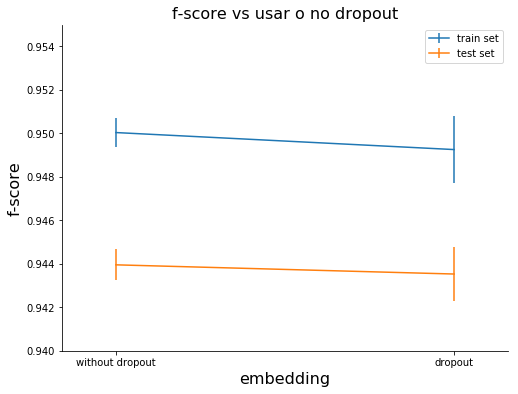

In [6]:
plot_frame('f-score vs usar o no dropout', 'embedding','f-score')
labels = ['without dropout','dropout']
placement = np.array([0,1])
plt.errorbar(placement, np.array([wtr[-2],dtr[-2]]),yerr=np.array([wtr[-1],dtr[-1]]),label='train set')
plt.errorbar(placement, np.array([wts[-2],dts[-2]]),yerr=np.array([wts[-1],dts[-1]]),label='test set')

#plt.bar(placement+0.1, results_test, width=0.2, label='Test set')
plt.bar(labels, [0,0], width=0.2, align='center')
#plt.title('f-score vs tamaño de embedding')
#plt.xlabel('embedding')
plt.ylim(0.94,0.955)
plt.legend()
plt.show()

> Teniendo en consideración la escala del eje Y, notamos que los resultados son prácticamente idénticos para el train y test set con dropout como sin dropout. Probablemente dropout no es necesario ya que las características entre vectores de embedding son independientes: cada palabra tiene su embedding y sus características no son compartidas. Entonces, el agregar dropout simplemente enmascara características que ya son las esenciales para la tarea en cuestión.

i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

> Una LSTM bidireccional procesa la sequencia en el orden entregado y además en el orden inverso. Así, para cada timestep de la secuencia se generan dos vectores de estado: uno que contiene toda la información del pasado y otro que contiene toda la información del futuro. Así, la predicción en cada paso se puede realizar utilizando ambos vectores, lo que se espera mejore el desempeño de un modelo en el que la tarea necesita de información proveniente de diferentes partes de la secuencia; no sólo del pasado.

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=n_lemmas+1, output_dim=embedding_vector, input_length=max_input_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode=concatenate))
model.add(Dense(n_labels+1, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

In [15]:
b3tr = np.loadtxt('bidirectional_3_train.txt')
b3ts = np.loadtxt('bidirectional_3_test.txt')

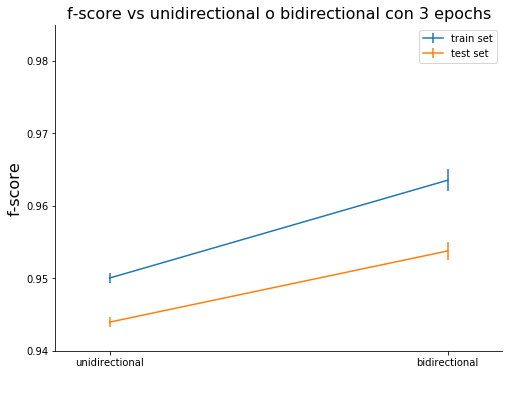

In [16]:
plot_frame('f-score vs unidirectional o bidirectional con 3 epochs', ' ','f-score')
labels = ['unidirectional','bidirectional']
placement = np.array([0,1])
plt.errorbar(placement, np.array([wtr[-2],b3tr[-2]]),yerr=np.array([wtr[-1],dtr[-1]]),label='train set')
plt.errorbar(placement, np.array([wts[-2],b3ts[-2]]),yerr=np.array([wts[-1],dts[-1]]),label='test set')
plt.bar(labels, [0,0], width=0.2, align='center')
plt.ylim(0.94,0.985)
plt.legend()
plt.show()

> Se observa que, tal como se esperaba, la LSTM bidireccional obtiene mejores resultados que la unidireccional tanto en train como en test. Ahora, debido a que el agregar más procesamiento aumenta la complejidad del modelo, puede que realizar más epochs mejore aún más los resultados obtenidos. Exploramos esta opción a continuación aumenta de 3 a 6 epochs.

In [7]:
b6tr = np.loadtxt('bidirectional_6_train.txt')
b6ts = np.loadtxt('bidirectional_6_test.txt')

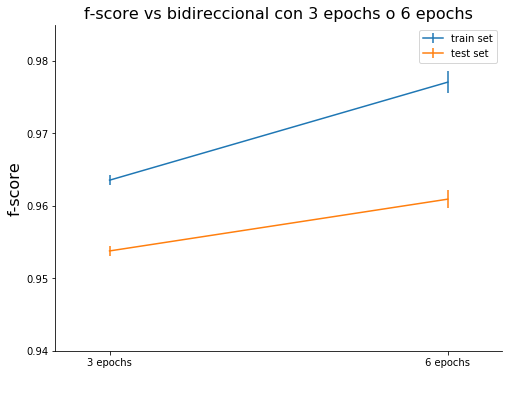

In [18]:
plot_frame('f-score vs bidireccional con 3 epochs o 6 epochs', ' ','f-score')
labels = ['3 epochs','6 epochs']
placement = np.array([0,1])
plt.errorbar(placement, np.array([b3tr[-2],b6tr[-2]]),yerr=np.array([wtr[-1],dtr[-1]]),label='train set')
plt.errorbar(placement, np.array([b3ts[-2],b6ts[-2]]),yerr=np.array([wts[-1],dts[-1]]),label='test set')

#plt.bar(placement+0.1, results_test, width=0.2, label='Test set')
plt.bar(labels, [0,0], width=0.2, align='center')
#plt.title('f-score vs tamaño de embedding')
#plt.xlabel('embedding')
plt.ylim(0.94,0.985)
plt.legend()
plt.show()

> Tal como se conjeturó, los resultados mejoran ligeramente al incrementar de 3 a 6 epochs, habiendo también un aumento en la variabilidad de los resultados. Esto es de esperar, pues el agregar capacidad a un modelo y ajustar más implica una mayor "exploración" del espacio de hipótesis, traduciéndose en resultados más diversos.

j) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. **Entrene la red definida en f) y compare al utilizar esta funcionalidad de enmascarar el valor 0 en este caso para el *default* de la capa *embedding***, comente sobre las curvas de entrenamiento y los tiempos de entrenamiento.

> Lo que realiza la capa de masking es ignorar completamente aquellas entradas con valor 0 en la actualización del estado de la red recurrente. Así, el estado sólo se actualizará en aquellos timesteps en los que haya información relevante, calculando el gradiente también tan sólo en estos puntos. Esto trae consigo 3 ventajas:
- El tipo de padding ya no afecta a la memoria de la red o al cálculo del gradiente, con lo que los resultados con pos y pre padding deberían ser muy similares 
- La pérdida del modelo se calcula sobre aquellos time-steps relevantes, lo cual es importante si queremos utilizar técnicas como early-stopping.
- La actualización de estado ya no se calcula sobre toda la secuencia, con lo que aumenta la eficiencia computacional del modelo.
>A continuación, correremos experimentos para comparar el modelo sin masking y con masking, para ver si el efecto negativo del padding mencionado en secciones anteriores se elimina. En esta misma línea, utilizaremos masking con padding antes y después, tan sólo para mostrar que ahora el tipo de padding es irrelevante.

In [29]:
msk_pre_train = np.loadtxt('mask_train_pre.txt')
msk_pre_test = np.loadtxt('mask_test_pre.txt')
msk_pos_train = np.loadtxt('mask_train_post.txt')
msk_pos_test = np.loadtxt('mask_test_post.txt')

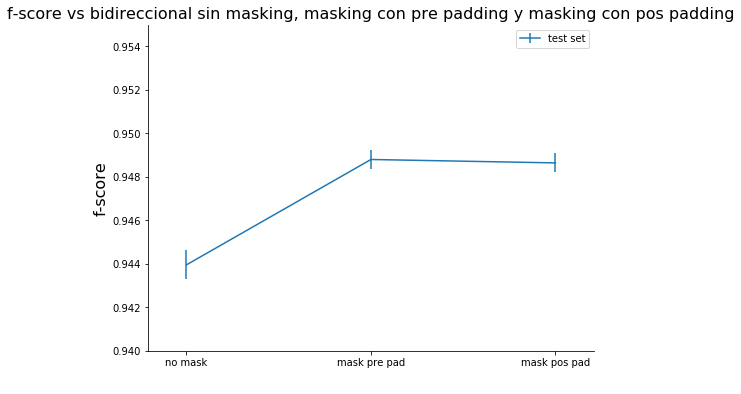

In [37]:
plot_frame('f-score vs bidireccional sin masking, masking con pre padding y masking con pos padding', ' ','f-score')
labels = ['no mask','mask pre pad', 'mask pos pad']
placement = np.array([0,1,2])
plt.errorbar(placement, np.array([wts[-2],msk_pre_test[-2],msk_pos_test[-2]]),yerr=np.array([wtr[-1],msk_pre_test[-1],msk_pos_test[-1]]),label='test set')
#plt.errorbar(placement, np.array([b3ts[-2],b6ts[-2]]),yerr=np.array([wts[-1],dts[-1]]),label='test set')

#plt.bar(placement+0.1, results_test, width=0.2, label='Test set')
plt.bar(labels, [0,0,0], width=0.2, align='center')
#plt.title('f-score vs tamaño de embedding')
#plt.xlabel('embedding')
plt.ylim(0.94,0.955)
plt.legend()
plt.show()

> Tal como se esperaba, los resultados con masking mejoran ligeramente respecto de sin masking. Además, se observa que los resultados utilizando pre y pos padding son casi idénticos (notar la escala del eje y), por lo que se ve empíricamente que la decisión del tipo de padding se vuelve irrelevante.

> A continuación, veremos cómo cambia el error y el error de validación durante el entrenamiento del modelo, con y sin masking.

### Error de entrenamiento con y sin masking

In [43]:
m_loss = np.loadtxt('mask_history.txt')
loss = np.loadtxt('history_without_mask.txt')
val_loss = np.loadtxt('val_history.txt')
mval_loss= np.loadtxt('val_mask_history.txt')

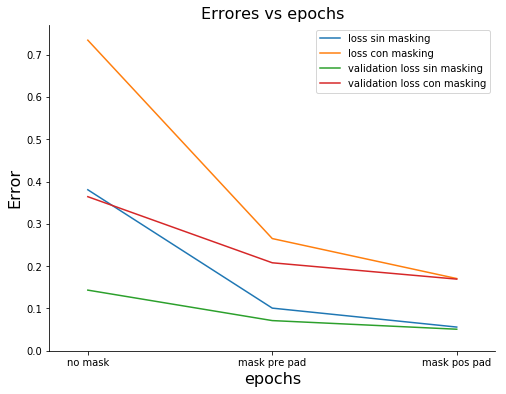

In [44]:
plot_frame('Errores vs epochs', 'epochs','Error')
#labels = ['no mask','mask pre pad', 'mask pos pad']
#placement = np.array([0,1,2])
#plt.plot(placement, np.array([wts[-2],msk_pre_test[-2],msk_pos_test[-2]]),label='loss')
plt.plot(loss, label='loss sin masking')
plt.plot(m_loss, label ='loss con masking')

plt.plot(val_loss, label='validation loss sin masking')
plt.plot(mval_loss, label ='validation loss con masking')
#plt.errorbar(placement, np.array([b3ts[-2],b6ts[-2]]),yerr=np.array([wts[-1],dts[-1]]),label='test set')

#plt.bar(placement+0.1, results_test, width=0.2, label='Test set')
plt.bar(labels, [0,0,0], width=0.2, align='center')
#plt.title('f-score vs tamaño de embedding')
#plt.xlabel('embedding')
#plt.ylim(0.94,0.955)
plt.legend()
plt.show()

> El error ahora no es tan optimista como lo era antes. Probablemente sea fácil para el modelo generar las predicciones correctas en los sectores donde hay padding. Además, como vimos de la distribución del largo de las sentencias, probablemente la clase asociada al padding sea la mayoritaria, influyendo abruptamente en la loss y validation loss. Finalmente, veremos como cambian los tiempos de entrenamiento con 1 sin masking:

### Tiempo sin masking
<img src="no_mask_time.JPG" width="70%" />

### Tiempo con masking
<img src="mask_time.JPG" width="70%" />

>Si bien la ganancia en tiempo no es tan grande, hay que considerar que si quisieramos hacer experimentos a gran escala, probando con una mayor cantidad de combinaciones de parámetros y quizás con un corpus más grande, este porcentaje de speed up sí podría resultar relevante.

k) En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras.

>En esta sección utilizaremos distintas combinaciones de parámetros con tal de mejorar los resultados obtenidos en las secciones anteriores. Los parámetros que hemos variado son:
- Epochs: 3, 6 y 9
- Capas: 1 y 2.
- Bloques por capa: 100, 150, 200 para 1 capa y 20, 50, 100 para 2 capas.
- Unidireccional y Bidireccional.

>La red es la LSTM, la capa de embedding tiene dimensión 120, se utilizó masking y no se utilizó dropout. Los experimentos se corrieron 5 veces y la tabla muestra el promedio de los resultados.

In [238]:
import os
results = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if "k_(" in filename:
            params = filename[3:-5].split(',')
            results.append([int(params[0]),int(params[1]),params[2]==' True',1, np.loadtxt(filename)[0]])
        if "k_2" in filename:
            
            #print(filename)
            #print(filename[3:-5].split(','))
            params = filename[11:-5].split(',')
            results.append([int(params[0]),int(params[1]),params[2]==' True',2, np.loadtxt(filename)[0]])
        

In [241]:
frame = pd.DataFrame(results, columns=['epochs','bloques por capa','bidireccional','capas','f1-score promedio'])

In [240]:
frame

,epochs,bloques por capa,bidireccional,capas,f1-score
0,3,150,True,1,0.958909
1,3,200,False,1,0.950831
2,3,200,True,1,0.957611
3,3,150,False,1,0.949840
4,6,100,False,1,0.954205
5,6,100,True,1,0.962614
6,6,150,False,1,0.955088
7,6,150,True,1,0.963456
8,6,200,False,1,0.955791
9,6,200,True,1,0.963391


In [87]:
np.max(frame['test error'])

0.9654049465688431

In [92]:
frame.iloc[np.argmax(frame['test error']),:]

epochs                     9
bloques por capa         200
bidireccional           True
capas                      1
test error          0.965405
Name: 15, dtype: object

> Los mejores resultados se obtienen entrenando con 9 epochs, 1 capa, 200 bloques de memoria y utilizando la LSTM bidireccional. Aún así, los resultados están tan cercanos unos de otros que habría que realizar un test de hipótesis para poder determinar si la diferencia es significativa o no.

l) Utilice la red entranda anteriormente, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.  

In [232]:
with open('ejemplos.txt','r') as file:
    print("{:15}: {} {}".format("Lemma", "Pred", "Real"))
    for line in file.readlines():
        if line !=' ':
            l = line.split(' ')
            print("{:15}: {} {}".format(l[0],l[1],l[2][:-1]))

Lemma          : Pred Real
amnesti        : O O
also           : O O
accus          : O O
eritrean       : B-gpe B-gpe
prison         : O O
offici         : O O
of             : O O
open           : O O
fire           : O O
on             : O O
detaine        : O O
at             : O O
the            : O O
adi            : B-geo B-geo
abeto          : I-geo I-geo
prison         : O O
dure           : O O
an             : O O
appar          : O O
escap          : O O
attempt        : O O
follow         : O O
the            : O O
arrest         : O O
.              : O O
the            : O O
bird           : O O
gave           : O O
no             : O O
credenc        : O O
to             : O O
these          : O O
warn           : O O
word           : O O
,              : O O
but            : O O
consid         : O O
the            : O O
owl            : O O
to             : O O
be             : O O
besid          : O O
herself        : O O
and            : O O
said           : O O
that

> Notamos de los ejemplos mostrados la gran capacidad del modelo para etiquetar correctamente las palabras.  No se observan errores en entidades de 1 palabra, pero con 2 o más el modelo muestra tener algunos problemas. Por ejemplo, "prime minist ahmad chalabi" es etiquetado  sólo en las últimas 2 palabras, y de forma equivocada. "new delhi" es reconocida por el algoritmo como una sola entidades, sin embargo, notamos que "new" es etiquetado como "B-geo" mientras que "delhi" es etiquetado como "I-per". Es decir, el algoritmo no aprendió a que la decisión tomada en el paso anterior, sobre si la entidad compartida es una persona o una organización, debe mantener el mismo tipo de predicción hasta terminar de etiquetar la entidad. En otros casos, cuando aparecen entidades distintas pero contiguas en el texto, el modelo las mezcla. En otros, confunde organizaciones con personas y demás. Aún así es destacable el comportamiento del algoritmo, teniendo en consideración que quizás muchas de estas entidades no habían aparecido nunca en el train set y por ende su embedding no debiese estar entrenado. Sería interesante analizar si el modelo, en esos casos, es capaz de inferir el tag a partir del contexto.

Ahora utilizaremos el mismo dataset para realizar una aplicación más conocida hoy en día que es el autocompletar texto, esto es, predecir la siguiente palabra de una sentencia basada en las palabras anteriores de la misma, por lo que la red que utilizaremos es del tipo many to one.
Debido a lo extenso del vocabulario es bastante complejo hacer un modelo que prediga una palabra dentro de las millones que pueden haber, por lo que, trabajaremos a nivel de carácter, en donde las posibilidades (posibles clases) son mucho menores.

m) **Carge las palabras del dataset** ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). **Utilice el tamaño del *corpus* que le acomode a la memoria de su computador**.

> En una tarea de autocompletar texto utilizar lemmas sería perjudicial, ya que el texto lematizado carece de sentido. Es decir, no podríamos generar algo coherente si no tenemos las palabras conjugadas dependiendo del contexto. Además, ya que vamos a trabajar a nivel de caracteres, el modelo puede aprender estructuras morfológicas que se pierden al utilizar lemmas y que pueden ayudar a darle sentido al texto aún si este contiene vocabulario no antes visto (como la conjugación usando la  terminación "mente" de una palabra vista en el train set, pero su utilización como adverbio no antes vista).

In [92]:
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
maxlen = 40 # cut the text in semi-redundant sequences of maxlen characters
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.5) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

total chars: 72
nb sequences: 12127


> Trabajaremos con el 50% del corpus.

In [80]:
def map_to_dict(word):
    try:
        classes[word] += 1
    except:
        classes[word] = 1

classes = {}

list(map(map_to_dict,next_chars)) 
    
class_list = []
frequencies = []

for word, count in classes.items():
    class_list.append(word)
    frequencies.append(count)

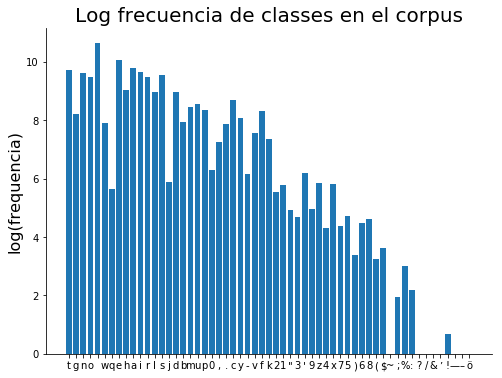

In [84]:
plt.figure(figsize=(8,6))
ax =plt.subplot(111)
x = np.arange(50)
plt.bar(class_list,np.log(frequencies))
#plt.plot(recall)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.ylabel("log(frequencia)", fontsize=16)
#plt.xlabel("largo de sentencia", fontsize=16)
#plt.xlim(0,len(signal)+24)
#plt.ylim(-0.1,1.1)
plt.title('Log frecuencia de caracteres en el corpus', fontsize=20)
#plt.xticks(rotation='vertical')
plt.show()

> Nos encontramos nuevamente con un problema de clases desbalanceado, teniendo caracteres con muy poca ocurrencia mientras que otros sí son utilizados ampliamente.

n) **Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres**, tal cual se realizó en c) con los *lemmas*, **lo mismo para las etiquetas**. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. **Transforme las etiquetas a *one hot vector*** como se realizó en c) y **defina la red** similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA)[[2]](#refs) para *Deep Neural Network*. 

> Notamos que por construcción, cada segmento de sentencia tiene largo 41, por lo cual no es necesario realizar padding. Aún así, otorgaremos a la red recurrente con la capacidad de procesar sequencias de cualquier tamaño. Esto se realiza entregándole "None" a "input_length" en la capa de embedding. Esto será útil durante la generación de texto de prueba, ya que podemos volver a alimentar a la red cada vez con una sentencia más grande y no sólo con los últimos 41 caracteres. 

In [139]:
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
dataY = to_categorical(dataY, num_classes=len(chars))

from keras.models import Sequential
from keras.layers import CuDNNGRU,GRU,Embedding, Dropout, Dense, LSTM
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=None))
model.add(GRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

> La GRU es una red recurrente similar a la LSTM, pero sólo con 2 compuertas: reset, que controla cuanta información del pasado será utilizada para construir el nuevo input, y update, que nivela que porcentaje del estado anterior y del nuevo input son utilizados para la construcción del nuevo estado. La mayor ventaja que tiene la GRU sobre la LSTM es su eficiencia computacional, habiendo muchos estudios inconcluyentes respecto a de cuál de las dos redes tiene mejor desempeño en cuanto a accuracy de las tareas.

o) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente **¿Cuál es la técnica para predecir el siguiente carácter?**

> La técnica para realizar la predicción es la de, dadas las probabilidades computadas por la capa softmax luego de recibir el último caracter de la sentencia, elegir el siguiente caracter aleatoriamente a partir de tales probabilidades, asumiendo una distribución multinomial.

In [145]:
def predict_next_char(model, sentence, mode = 'random'):
    """Predict the next character from the current one"""    
    x_pred = np.array([char_indices[null_character]]+[char_indices[char] for char in sentence]).reshape(1,-1)
    
    #x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0).flatten()
    #print(preds.shape)
    if mode == 'random':
        next_index = np.random.choice(len(chars), p=preds) #take a sample
    elif mode == 'max':
        next_index = np.argmax(preds)
    return indices_char[next_index]


In [ ]:
import random,sys
def on_epoch_end(epoch, logs):
    """Function invoked at end of each epoch. Prints generated text."""
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence)
        sentence = sentence[:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(np.array(dataX[:100]), np.array(dataY[:100]),batch_size=256,epochs=25, callbacks=[print_callback])

p) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. **Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.**

> Para verificar la calidad del modelo, generaremos 10 trozos de sentencia aleatorios a partir del texto y generaremos sus predicciones tanto usando el enfoque aleatorio como el enfoque determinista (max). Los resultados son leídos a partir de los archivos "sentences.txt" y "max_sentences.txt", construidos al entrenar el modelo en los computadores del INCA.

In [ ]:
max_sentences = []
sentences = []

from keras.models import load_model
import random,sys

for j in range(10):
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    
    original_sentence = sentence[:]
    
    for i in range(400):
            next_char = predict_next_char(model, sentence,'max')
            sentence = sentence + next_char 
            sys.stdout.write(next_char)
            sys.stdout.flush()
            
    max_sentences.append(sentence)
    sentence = original_sentence[:]
    
    for i in range(400):
            next_char = predict_next_char(model, sentence,'random')
            sentence = sentence + next_char 
            sys.stdout.write(next_char)
            sys.stdout.flush()
    sentences.append(sentence)
    
with open('sentences.txt',w) as file:
    for s in sentences:
        file.write(s)
        
with open('max_sentences.txt',w) as file:
    for s in max_sentences:
        file.write(s)

### Predicción estocástica

In [235]:
with open('sentences.txt') as file:
    for line in file.readlines():
        print(line)

seed :d russia has been troubled by some u.s. 

d russia has been troubled by some u.s. and devesting lawnens arried to venezueli -boltar attacksion of rassian trade . it  entired anti-devestry for politicians carries and tuesday is , cilitian assessaint are still said thursday . singovich secretary gen negati says the russian noel country , over the nexichenco rejectives and pakistan 's sope .nia to idaq , and wollling in a senator million boic to together the military stafefy mine 

seed :mohammed . on saturday , diplomats from 

mohammed . on saturday , diplomats from the start in president bud for native president dafmo sere along the ochumani gats edmatezads reneement at one meeting to the group . a report . egypt ha dossein , police says it lighted iraqi nets eoven fer dif sixnates sub tely have a classafbion has rejected china in the new orleanse is cotsil and from the poll using belognaliament everyayences . outing the estimated militant groups . europe . 

seed :for canada . m

>Notamos en este caso que las predicciones, en muchas ocasiones, realmente conforman palabras que tienen sentido, pertenecientes al vocabulario de palabras en inglés. En otros casos, sin embargo, las palabras carecen de sentido. Debido a que el corpus corresponde a noticias políticas internacionales, las predicciones siempre convergen a palabras de guerra, aunque la semilla no haya tenido nada que ver con ello, como es el caso de "ice cube 's family comedy are we done y", en la que rápidamente se empiezan a producir palabras asociadas a violencia. Entrenar en un corpus más diverso debería quitar este cesgo. La coherencia del texto entero, por otro lado, es algo que el modelo no es capaz de capturar. Eso de por sí es una tarea mucho más compleja y requiere de otro enfoque. 

>Finalmente, notamos que los caracteres de menor frecuencia en el corpus, tales como "?" nunca aparecen en las predicciones: son tan pocas las instancias de entrenamiento con estos caracteres que la red nunca aprende su contexto.

### Predicción max

In [237]:
with open('max_sentences.txt') as file:
    for line in file.readlines():
        print(line)

seed :d russia has been troubled by some u.s. 

d russia has been troubled by some u.s. secretary of state condoleezza rice and the southern purtureled by the region . the spanish army says it is concerned the country 's president bush the party of the region . the u.s. military says it has not seek to the southern political countries . the u.s. military says it has not allow the possibility for the state of paraciay , and the support for the party of the region . the u.s. military s

seed :mohammed . on saturday , diplomats from 

mohammed . on saturday , diplomats from the second production . the u.s. military says it has not seek to the southern political countries . the u.s. military says it has not allow the possibility for the state of paraciay , and the support for the party of the region . the u.s. military says it has not seek to the southern political countries . the u.s. military says it has not allow the possibility for the state of paraciay , and the 

seed :for canada . m

> En las predicciones utilizando el enfoque determinista, se observa que hay una rápida convergencia siempre a las mismas palabras. Esto sugiere que las dinámicas aprendidas por la red recurrente tienen un atractor en el espacio multidimensional, por ende, independiente de la semilla, se terminará convergiendo a las palabras asociadas a la dinámica del atractor. En el caso de las predicciones estocásticas, es claro que son las perturbaciones las que logran sacar al modelo de este estado estacionario, tal como una ecuación de diferencias con un estado estacionario se convierte en un modelo auto-regresivo cuando se le agrega ruido blanco en cada instante t. Sería interesante que el modelo lograra aprender múltiples atractores, en donde cada atractor contenga palabras asociadas a una témica del corpus, y así, diferentes semillas lleven a diferentes resultados aún en el caso determinista.